
# $\color{Gray}{\textbf{Data-Informed Inversion Model to retrieve marine optical constituents in the BUOSSOLE site: Code availability} }$



Within the New Copernicus Capability for Trophic Ocean Networks (NECCTON) project, we aim to improve the
current data assimilation system by developing a method for accurately estimating marine optical constituents from satellite
derived Remote Sensing Reflectance. In the next modules, we present a functional version of the codes used for the project. The complete code can be found in https://github.com/carlossoto362/OGS_one_d_model.

##Loading the modules

First, we load the necessary python modules, and data requiered.

In [1]:
#@title Loading the packages
!rm -f -r ./OGS_one_d_model
!echo cloning the repository
!git clone https://github.com/carlossoto362/OGS_one_d_model
!echo lets see how the file looks like
!ls /content/OGS_one_d_model
%env OGS_ONE_D_HOME_PATH=/content/OGS_one_d_model
!echo lets import some labraries
!pip3 install jupyprint ray ConfigSpace

import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
import jupyprint as jp
from datetime import datetime,timedelta
from torch.utils.data import DataLoader,random_split
import warnings
import os
import sys
sys.path.insert(1, "/content/OGS_one_d_model/PySurfaceData")

warnings.filterwarnings('ignore')

cloning the repository
Cloning into 'OGS_one_d_model'...
remote: Enumerating objects: 664, done.
remote: Counting objects: 100% (664/664), done.
remote: Compressing objects: 100% (444/444), done.
remote: Total 664 (delta 339), reused 427 (delta 217), pack-reused 0 (from 0)
Receiving objects: 100% (664/664), 15.76 MiB | 9.97 MiB/s, done.
Resolving deltas: 100% (339/339), done.
lets see how the file looks like
bayes_parameters  mcmc			 results_bayes_lognormal_gaussparam   results_NN
bnap_exp.py	  npy_data		 results_bayes_lognormal_logparam     results_NN_NNparam
cst.csv		  plot_data		 results_bayes_lognormal_mcmcParam    results_VAE2_VAEparam
cte_lambda.csv	  PySurfaceData		 results_bayes_lognormal_NNparam      results_VAE_VAEparam
Jacobians	  README		 results_bayes_lognormal_unperturbed  time_experiments
LICENSE		  requirements.txt	 results_bayes_lognormal_VAEparam     VAE_model
makefile	  results_bayes_AM_test  results_bayes_optimized	      venv_intructions.txt
env: OGS_ONE_D_HOME_PATH

We would also like to import a module to read the data we are going to use. The library is called read_data_module and is stored in the PySurfaceData library. After importing it, let's select the test data to work with. We used the train data for work, while test data was left only for testing the results. In this module, let's use the test data since is a smaller set. The seed used for selecting the data was 1853.


In [2]:

my_device = 'cpu'
if 'OGS_ONE_D_HOME_PATH' in os.environ:
    HOME_PATH = MODEL_HOME = os.environ["OGS_ONE_D_HOME_PATH"]
else:

    print("Missing local variable OGS_ONE_D_HOME_PATH. \nPlease add it with '$:export OGS_ONE_D_HOME_PATH=path/to/ogs/one/d/model'.")
    sys.exit()

import OGS_one_d_model.PySurfaceData.read_data_module as rdm


data = rdm.customTensorData(data_path=MODEL_HOME + '/npy_data',which='test',per_day = True,randomice=True,seed=1853,normilized_NN='scaling')
#print(help(data))
constant = rdm.read_constants(file1=MODEL_HOME + '/cte_lambda.csv',file2=MODEL_HOME + '/cst.csv',my_device = my_device)

print('printing column names of OASIM model data: ',data.x_column_names)
print('printing column names of satellite data',data.y_column_names)
print('Printing dictionary with the constants of the model: ',constant)



printing column names of OASIM model data:  ['Edif_412', 'Edif_442', 'Edif_490', 'Edif_510', 'Edif_555', 'Edir_412', 'Edir_442', 'Edir_490', 'Edir_510', 'Edir_555', 'lambda_412', 'lambda_442', 'lambda_490', 'lambda_510', 'lambda_555', 'zenith', 'PAR']
printing column names of satellite data ['RRS_412', 'RRS_442', 'RRS_490', 'RRS_510', 'RRS_555']
Printing dictionary with the constants of the model:  {'absortion_w': tensor([0.0027, 0.0057, 0.0146, 0.0330, 0.0610]), 'scattering_w': tensor([0.0054, 0.0044, 0.0028, 0.0025, 0.0017]), 'backscattering_w': tensor([0.0027, 0.0022, 0.0014, 0.0012, 0.0008]), 'absortion_PH': tensor([0.0340, 0.0400, 0.0280, 0.0180, 0.0090]), 'scattering_PH': tensor([0.0210, 0.0202, 0.0205, 0.0205, 0.0191]), 'backscattering_PH': tensor([5.3800e-05, 5.1800e-05, 5.2600e-05, 5.2500e-05, 4.8800e-05]), 'dCDOM': 0.015, 'sCDOM': 0.017, 'dNAP': 0.0013, 'sNAP': 0.013, 'eNAP': 0.0287, 'fNAP': 0.5, 'Theta_o': 0.03, 'Theta_min': 0.005, 'beta': 500.0, 'sigma': 20.0, 'rd': 1.0, 'r

We would also like to load the forward model, also stored in the PySurfaceData library.

In [3]:
import OGS_one_d_model.PySurfaceData.Forward_module as fm

batch_size = data.len_data

model = fm.Forward_Model(num_days=1).to(my_device)
#print(help(model))
X,Y = data.__getitem__(0)

def return_date(day):
  return datetime(year=2000,month=1,day=1) + timedelta(days = int(data.dates[0]))

jp.jupyprint("printing $E_{dir}, E_{dif}, \lambda, zenith, PAR$ for day" + " {}".format( return_date(data.dates[0]).strftime("%d/%m/%Y") ))
print(X)

jp.jupyprint("printing $R_{RS,412.5},R_{RS,442.5},R_{RS,490},R_{RS,510},R_{RS,555}$ for day " + "{}".format( return_date(data.dates[0]).strftime("%d/%m/%Y") ))
print(Y)


printing $E_{dir}, E_{dif}, \lambda, zenith, PAR$ for day 28/10/2010

tensor([[  4.9903,   4.1626, 412.5000,  57.3969, 203.7786],
        [  5.7392,   5.9532, 442.5000,  57.3969, 203.7786],
        [  5.5295,   7.2944, 490.0000,  57.3969, 203.7786],
        [  5.2077,   7.4361, 510.0000,  57.3969, 203.7786],
        [  4.6826,   7.7324, 555.0000,  57.3969, 203.7786]])


printing $R_{RS,412.5},R_{RS,442.5},R_{RS,490},R_{RS,510},R_{RS,555}$ for day 28/10/2010

tensor([0.0039, 0.0039, 0.0035, 0.0025, 0.0014])


Now, the $R_{RS}$ depends also in $(chla, NAP, CDOM)$, which, for now, we don't know. Let's define a random tensor, and use it to evaluate the function. We also need to specify the perturbation factors, which are values that modify the existing parameters. If we set all of them to 1, we would be using the parameters from the literature.

In [4]:
perturbation_factors = torch.ones(14, dtype=torch.float32)

chla = torch.rand((1,1,3))
RRS_OBS = Y
RRS_PRED = model(X.unsqueeze(0),perturbation_factors_ = perturbation_factors,constant=constant)
print(RRS_OBS,RRS_PRED)

tensor([0.0039, 0.0039, 0.0035, 0.0025, 0.0014]) tensor([[0.0027, 0.0025, 0.0029, 0.0031, 0.0028]], grad_fn=<DivBackward0>)


The values are not close to the measured ones, because we used random numbers as constituents. In our work, we used a Bayesian framework to find the optical constituents that maximized the posterior distribution, $p(z|y,x)$, where $z$ are the optical constituents, $chla,NAP,CDOM$, $y$ the satellite data, $R_{RS}$, and $x$ the OASIM model data, $E_{dir},E_{dif},\lambda,zenith, \text{PAR}$. Computationally, we defined a loss function, "RRS_loss" equal to $-2\log{(p(z|y,x))}$, part of the operational method, and minimized the loss function using a fix set of parameters.

To start, we defined a train loop, which using the Adam altorithm, minimizes the loss function "RRS_loss". The train loop is in the module bayes_inversion.py

In [5]:

import OGS_one_d_model.PySurfaceData.bayesian_inversion as bayes
print(help(bayes.train_loop))

Help on function train_loop in module OGS_one_d_model.PySurfaceData.bayesian_inversion:

train_loop(data_i, model, loss_fn, optimizer, N, kind='all', num_days=1, my_device='cpu', constant=None, perturbation_factors_=None, scheduler=True)
    The train loop evaluates the Remote Sensing Reflectance RRS for each wavelength >>>pred=model(data_i), evaluates the loss function
    >>>loss=loss_fn(pred,y), evaluates the gradient of RRS with respect to the parameters, >>>loss.backward(), modifies the value of the parameters according to the optimizer criterium, >>>optimizer.step(),
    sets the gradient of RRS to zero. After this, compute the approximate covariance matrix of the active constituents to, finally, compute kd and bbp with uncertainty. 
    
    Parameters:
    
      data_i: tuple of datasets (X,Y), X is the input data E_dir(lambda), E_dif(lambda), lambda, zenith(lambda) and PAR(lambda), a tensor of dimension (*,5,5), where * stands for the number of days evaluated. Y is the satell

We also want to optimize the forward model by optimizing his parameters, such that the inversion returns values close to observe data. For this, we also defined a loss function, OBS_loss, and minimize it. Since for each iteration of the minimization of OBS_loss, involves a train loop minimizing RRS_loss, we started by finding an approximation of the minimum of both by using alternate minimization. The function that does the alternate minimization is track_parameters, also in the module bayesian_inversion.

In [6]:
perturbation_factors = bayes.track_parameters(data_path = MODEL_HOME + '/npy_data',output_path = MODEL_HOME + '/plot_data/perturbation_factors',iterations=100,save=False,which = 'test', seed = 1853,name='history.npy')
print(perturbation_factors[-1])

0 loss:  0.07606784254312515
10 loss:  0.10493814945220947
20 loss:  0.09000585228204727
30 loss:  0.08237601071596146
40 loss:  0.07792394608259201
50 loss:  0.075652115046978
60 loss:  0.07463227957487106
70 loss:  0.07413626462221146
80 loss:  0.07390021532773972
90 loss:  0.07375723123550415
Total time:  88.14818072319031
[1.0524969  1.053302   0.94676924 1.0534145  0.9465751  1.0475943
 0.8928814  1.0537297  0.94545877 1.0553963  1.0491184  1.0546482
 1.0559957  0.9470564 ]



The Alternate Minimization manage to minimize both loss functions, RRS_loss and OBS_loss, but doesn't help us if we want to quantify the uncertainty. For that, we used the Metropolis algorithm to sample for the posterior, using $e^{-(0.5)OBS_{loss}}$ as the model for the likelihood. Again, our likelihood depends in chla, nap and cdom, which are obtained by minimizing RRS_loss, so instead, we approximate the result by only performing a limited set of iterations. The final result is in the module sensitivity_analisys, together with the sensitivity analysis, which is not going to be part of this colab. Here we can save some time and load the MCMC runs, from the folder mcmc/ or the file mcmc/runs2/.  


In [6]:
    num_runs = 40
    mcmc_runs = np.empty((num_runs,3000,14))


    for i in range(num_runs):
        mcmc_runs[i] = np.load(MODEL_HOME + '/mcmc/run_' + str(i)+'.npy')

In addition, we also found values for the parameters using a framework called SGVB, which for now, I'm only going to mention that involves training a Neural Network. So, we can compare the mcmc parameters, the result of the Alternate Minimization (stored in /plot_data/perturbation_factors) and the results using a neural network. The full code availability is in the github, mension at the bigining of this Colab.

In [7]:
perturbation_factors = torch.tensor(np.load(MODEL_HOME + '/plot_data/perturbation_factors/perturbation_factors_history_AM_test.npy')[-1]).to(torch.float32)
perturbation_factors_NN = torch.tensor(np.load(MODEL_HOME + '/plot_data/perturbation_factors/perturbation_factors_history_CVAE_chla_centered.npy')[-300:]).to(torch.float32).mean(axis=0)

Using this two results, with the mcmc runs, we can make some plots to compare each other. For example:

[[1.43046848e-02 1.25091021e-02 5.00938437e+00 ... 5.46164398e+02
  2.47069634e+01 5.16654730e-03]
 [1.43099149e-02 1.25061968e-02 5.00806385e+00 ... 5.46151298e+02
  2.47057306e+01 5.16788042e-03]
 [1.43109706e-02 1.25013600e-02 5.00784300e+00 ... 5.46024708e+02
  2.47148855e+01 5.16807519e-03]
 ...
 [1.44985070e-02 1.20811243e-02 5.27082872e+00 ... 5.40522781e+02
  2.44085726e+01 5.20160537e-03]
 [1.45022146e-02 1.20737123e-02 5.27111821e+00 ... 5.40452418e+02
  2.44165513e+01 5.20277669e-03]
 [1.45027906e-02 1.20751213e-02 5.26977457e+00 ... 5.40631735e+02
  2.44138396e+01 5.20328110e-03]]


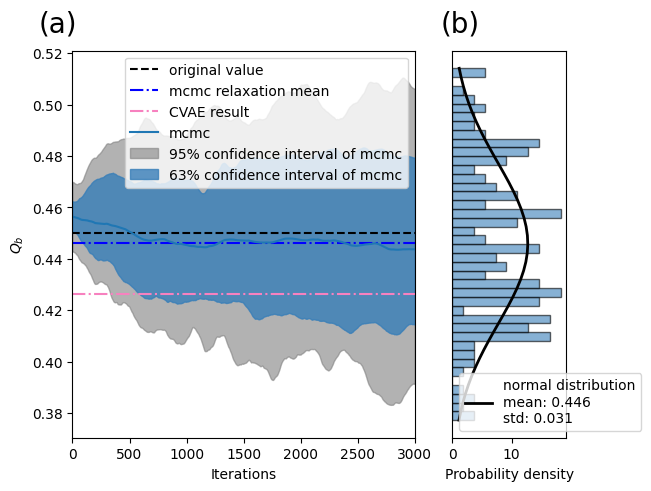

In [8]:
import matplotlib.pyplot as plt
constant_values = np.array([constant['dCDOM'],constant['sCDOM'],5.33,0.45,constant['Theta_min'],constant['Theta_o'],constant['beta'],constant['sigma'],0.005])


#mcmc_runs = mcmc_runs[:,2000:,:]
mcmc_runs_mean, mcmc_runs_std = np.empty((14)),np.empty((14))


#correlation_matrix(num_runs,mcmc_runs,plot=False,table=False)

mcmc_runs = mcmc_runs[:,:,5:] * constant_values

mcmc_runs_mean = np.mean(mcmc_runs,axis=0)
mcmc_percentile_2_5 = np.percentile(mcmc_runs,2.5,axis=0)

mcmc_percentile_98_5 = np.percentile(mcmc_runs,98.5,axis=0)
mcmc_percentile_16 = np.percentile(mcmc_runs,16,axis=0)
mcmc_percentile_84 = np.percentile(mcmc_runs,84,axis=0)


fig_labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
names = ['$d_{\\text{CDOM}}$ [$\\text{m}^2(\\text{mgCDOM})^{-1}$]','$S_{\\text{CDOM}}$ [nm]','$Q_a$','$Q_b$',\
             '$\Theta^{\\text{min}}_{\\text{chla}}$ [$\\text{mgChla}\\text{(mgC)}^{-1}$]','$\Theta^{\\text{0}}_{\\text{chla}}$  [$\\text{mgChla}\\text{(mgC)}^{-1}$]',\
             '$\\beta$ [$\\text{mmol}\\text{m}^{-2}\\text{s}^{-1}$]','$\sigma$  [$\\text{mmol}\\text{m}^{-2}\\text{s}^{-1}$]','$b_{b,\\text{NAP}}$']
which = 3
fig,axs = plt.subplots(ncols=2,nrows=1,layout='constrained',width_ratios=[3/4,1/4])

axs[0].axhline( y = constant_values[which],linestyle='--',label='original value',color='black')
print(mcmc_runs_mean)

axs[0].axhline( y = mcmc_runs_mean[500:,which].mean(),linestyle='dashdot',label='mcmc relaxation mean',color='blue')
axs[0].axhline( y = constant_values[which]*perturbation_factors_NN[5+which],linestyle='dashdot',label='CVAE result',color='#f781bf')



ynew = scipy.ndimage.uniform_filter1d(mcmc_runs_mean[:,which], size=100)
axs[0].plot(ynew,label='mcmc')

ynew1 = scipy.ndimage.uniform_filter1d(mcmc_percentile_2_5[:,which], size=100)
ynew2 = scipy.ndimage.uniform_filter1d(mcmc_percentile_98_5[:,which], size=100)
axs[0].fill_between(range(3000), ynew1, ynew2,color='gray',zorder = 0.1,alpha=0.6,label = '95% confidence interval of mcmc')

ynew1 = scipy.ndimage.uniform_filter1d(mcmc_percentile_16[:,which], size=100)
ynew2 = scipy.ndimage.uniform_filter1d(mcmc_percentile_84[:,which], size=100)
axs[0].fill_between(range(3000), ynew1, ynew2,color='#377eb8',zorder = 0.1,alpha=0.8,label = '63% confidence interval of mcmc')



axs[0].set_xlim(0,3000)
axs[0].text(-0.1,1.05,'(a)',transform = axs[0].transAxes,fontsize=20)
axs[0].set_ylabel(names[which])
axs[0].set_xlabel('Iterations')

axs[0].legend()

data = mcmc_runs[:,2000:,which]
data = data[:,::280].flatten()
data = data


n,bins,patches = axs[1].hist(data,orientation='horizontal',bins=40,edgecolor='black',color='#377eb8',alpha=0.6,density=True)
(mu, sigma) = scipy.stats.norm.fit(data)
axs[1].plot(scipy.stats.norm.pdf(bins,loc=mu,scale=sigma),bins , linewidth=2,color='black',label='normal distribution\nmean: {:.3f}\nstd: {:.3f}'.format(mu,sigma))
axs[1].legend()
axs[1].text(-0.1,1.05,'(b)',transform = axs[1].transAxes,fontsize=20)
axs[1].set_xlabel('Probability density')

axs[1].set_yticks([])
axs[0].set_ylim(*axs[1].get_ylim())
plt.show()

To compare between the different sets of parameters, we can do the operational minimization (the minimization of RRS_loss) with each of them, and compare the results. For example, the loop with unperturbed parameters would be done as follows: (can take a few minutes)




In [22]:
!mkdir /content/OGS_one_d_model/results_tests
data = rdm.customTensorData(data_path=MODEL_HOME + '/npy_data',which='test',per_day = True,randomice=False)

perturbation_factors = torch.ones(14)
#for alternate minimization values, you can use perturbation_factors = torch.tensor(np.load(MODEL_HOME + '/plot_data/perturbation_factors/perturbation_factors_history_AM_test.npy'))[-1].to(torch.float32)
#for alternate mcmc values, you can use perturbation_factors = torch.tensor(np.load(MODEL_HOME + '/plot_data/perturbation_factors/perturbation_factors_mean_mcmc.npy')).to(torch.float32)
#for values from the SGVB framework, you can use perturbation_factors = torch.tensor(np.load(MODEL_HOME + '/plot_data/perturbation_factors/perturbation_factors_history_CVAE_chla_centered.npy')).to(torch.float32)


my_device = 'cpu'
constant = rdm.read_constants(file1=MODEL_HOME + '/cte_lambda.csv',file2=MODEL_HOME + '/cst.csv',my_device = my_device)

lr = 0.029853826189179603
x_a = torch.zeros(3)
s_a_ = torch.eye(3)
s_e = (torch.eye(5)*torch.tensor([1.5e-3,1.2e-3,1e-3,8.6e-4,5.7e-4]))**(2)#validation rmse from https://catalogue.marine.copernicus.eu/documents/QUID/CMEMS-OC-QUID-009-141to144-151to154.pdf
batch_size = data.len_data
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
s_a = s_a_*4.9

model = fm.Forward_Model(num_days=batch_size).to(my_device)
model.perturbation_factors = perturbation_factors
loss = fm.RRS_loss(x_a,s_a,s_e,num_days=batch_size,my_device = my_device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

output = bayes.train_loop(next(iter(dataloader)),model,loss,optimizer,4000,kind='all',\
                        num_days=batch_size,constant = constant,perturbation_factors_ = perturbation_factors, scheduler = True)

output_path = MODEL_HOME+'/results_tests'
np.save(output_path + '/X_hat.npy',output['X_hat'])
np.save(output_path + '/kd_hat.npy',output['kd_hat'])
np.save(output_path + '/bbp_hat.npy',output['bbp_hat'])
np.save(output_path + '/RRS_hat.npy',output['RRS_hat'])
np.save(output_path + '/dates.npy',data.dates)

time for training... 28.784884691238403


The results of this runs are stored in files starting with ./result_, we can plot the results with a module called plot_data_lognormal.

/content/OGS_one_d_model


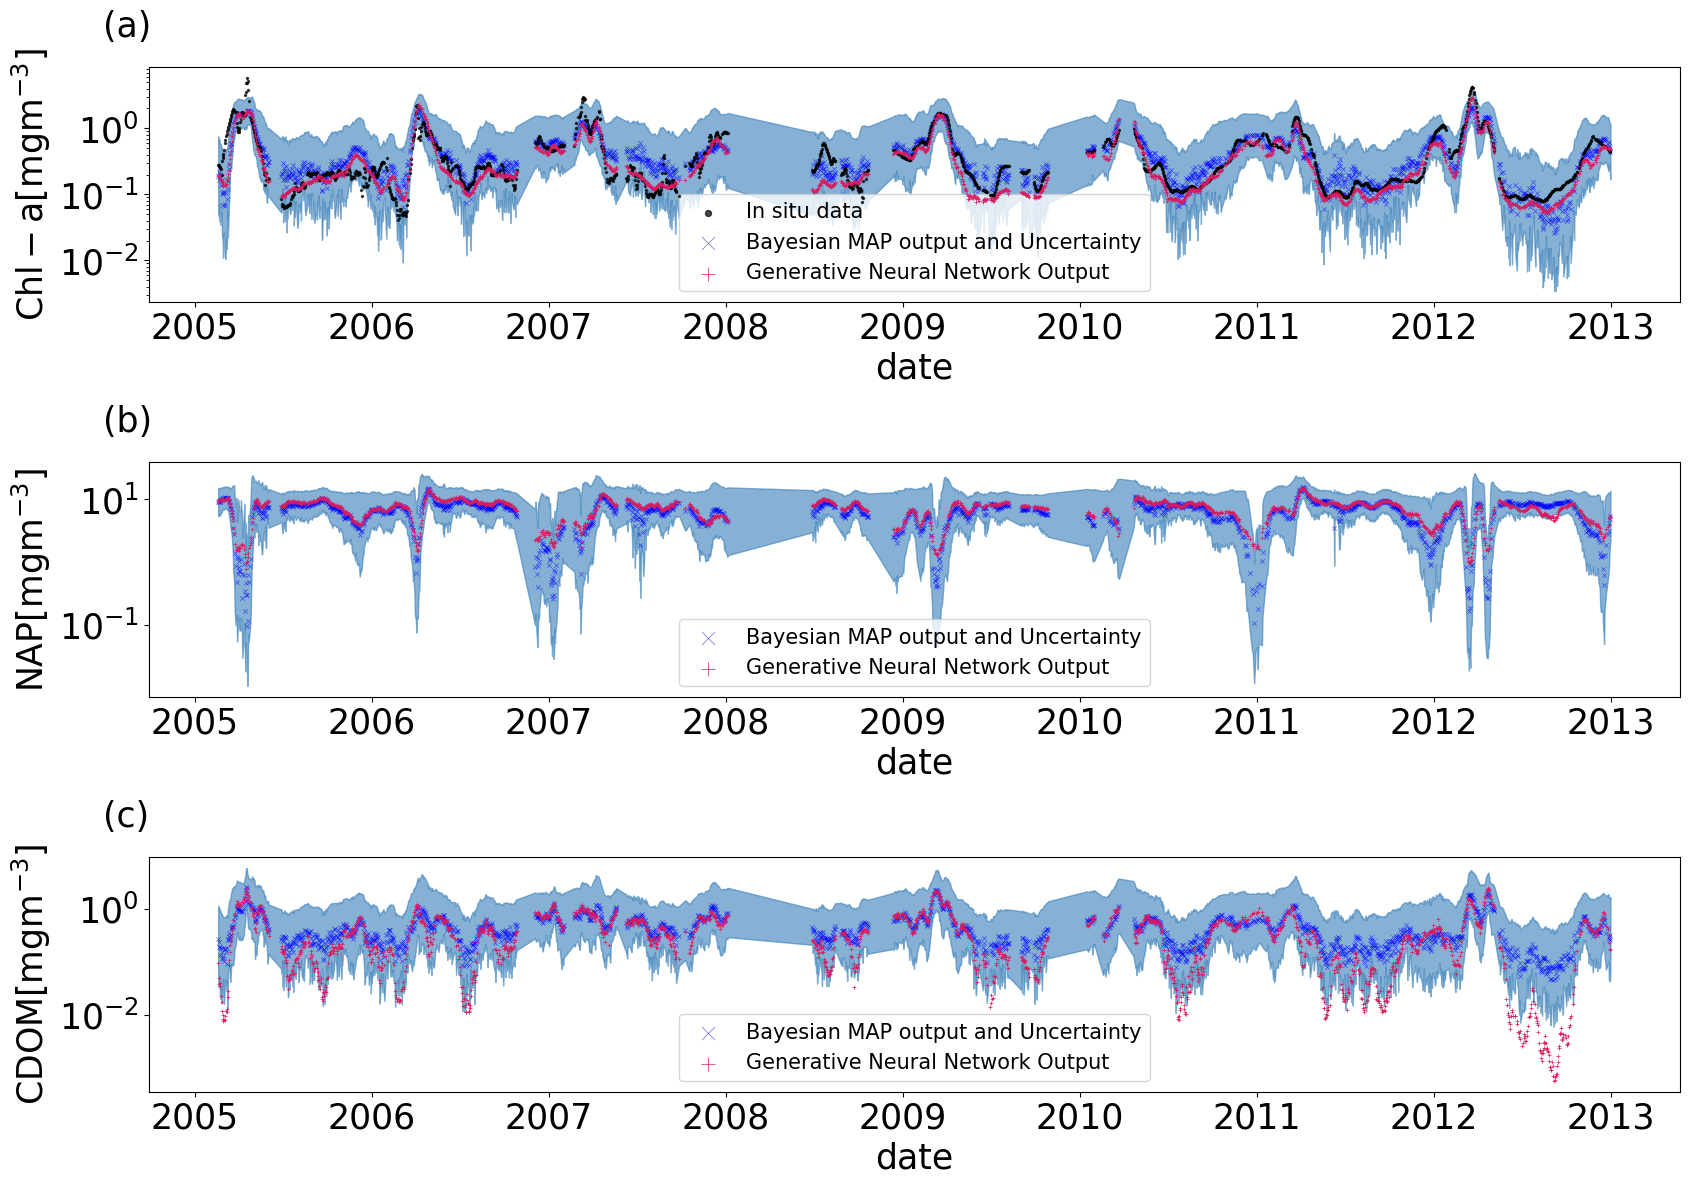

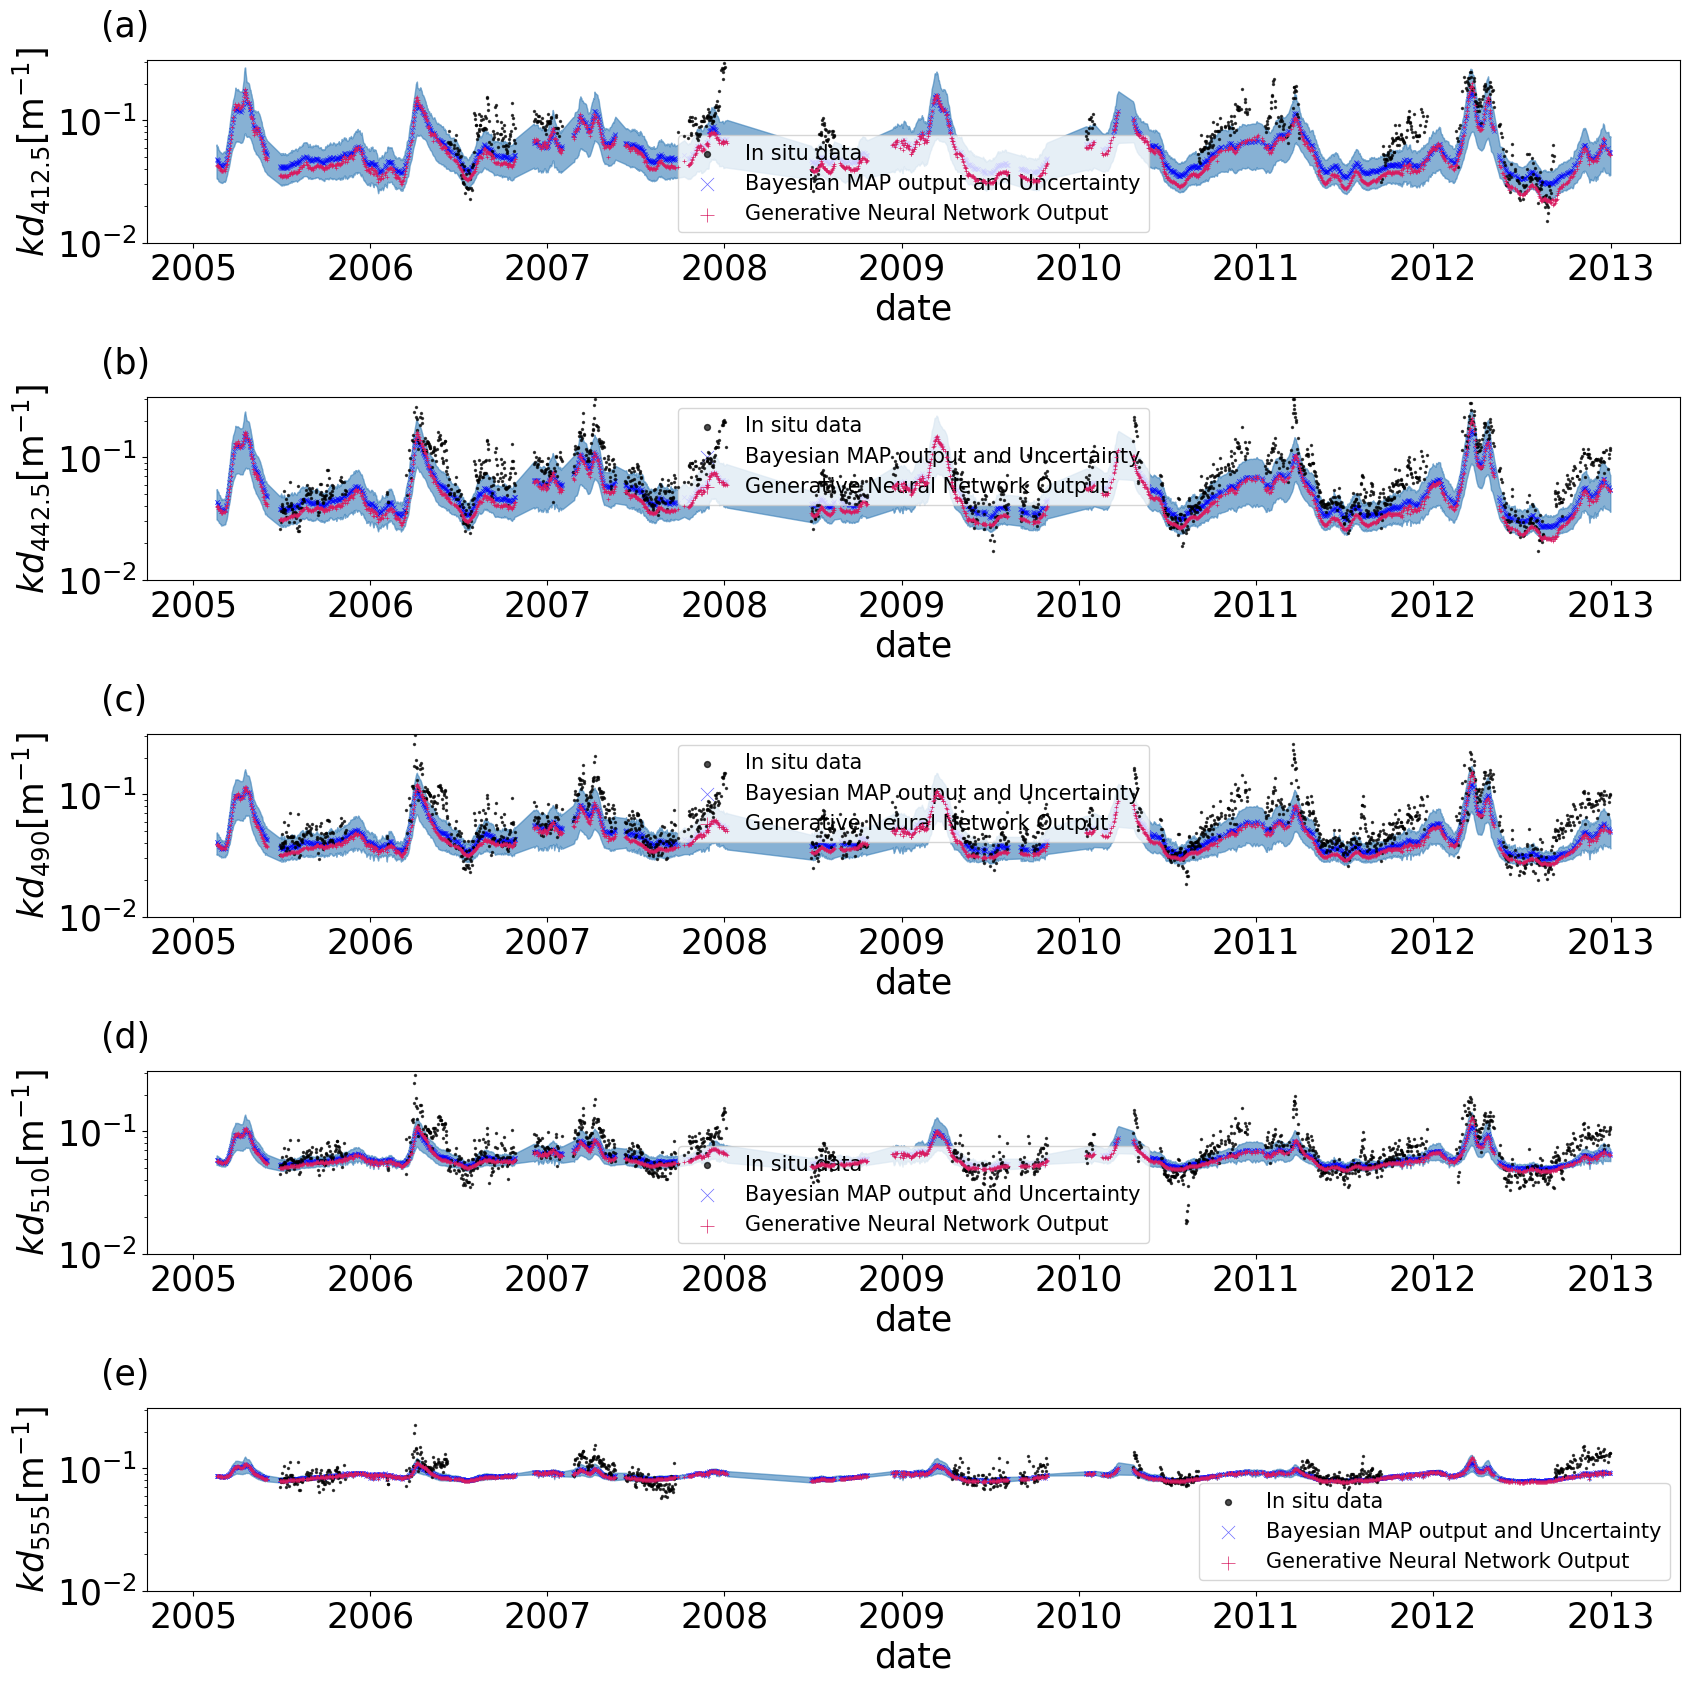

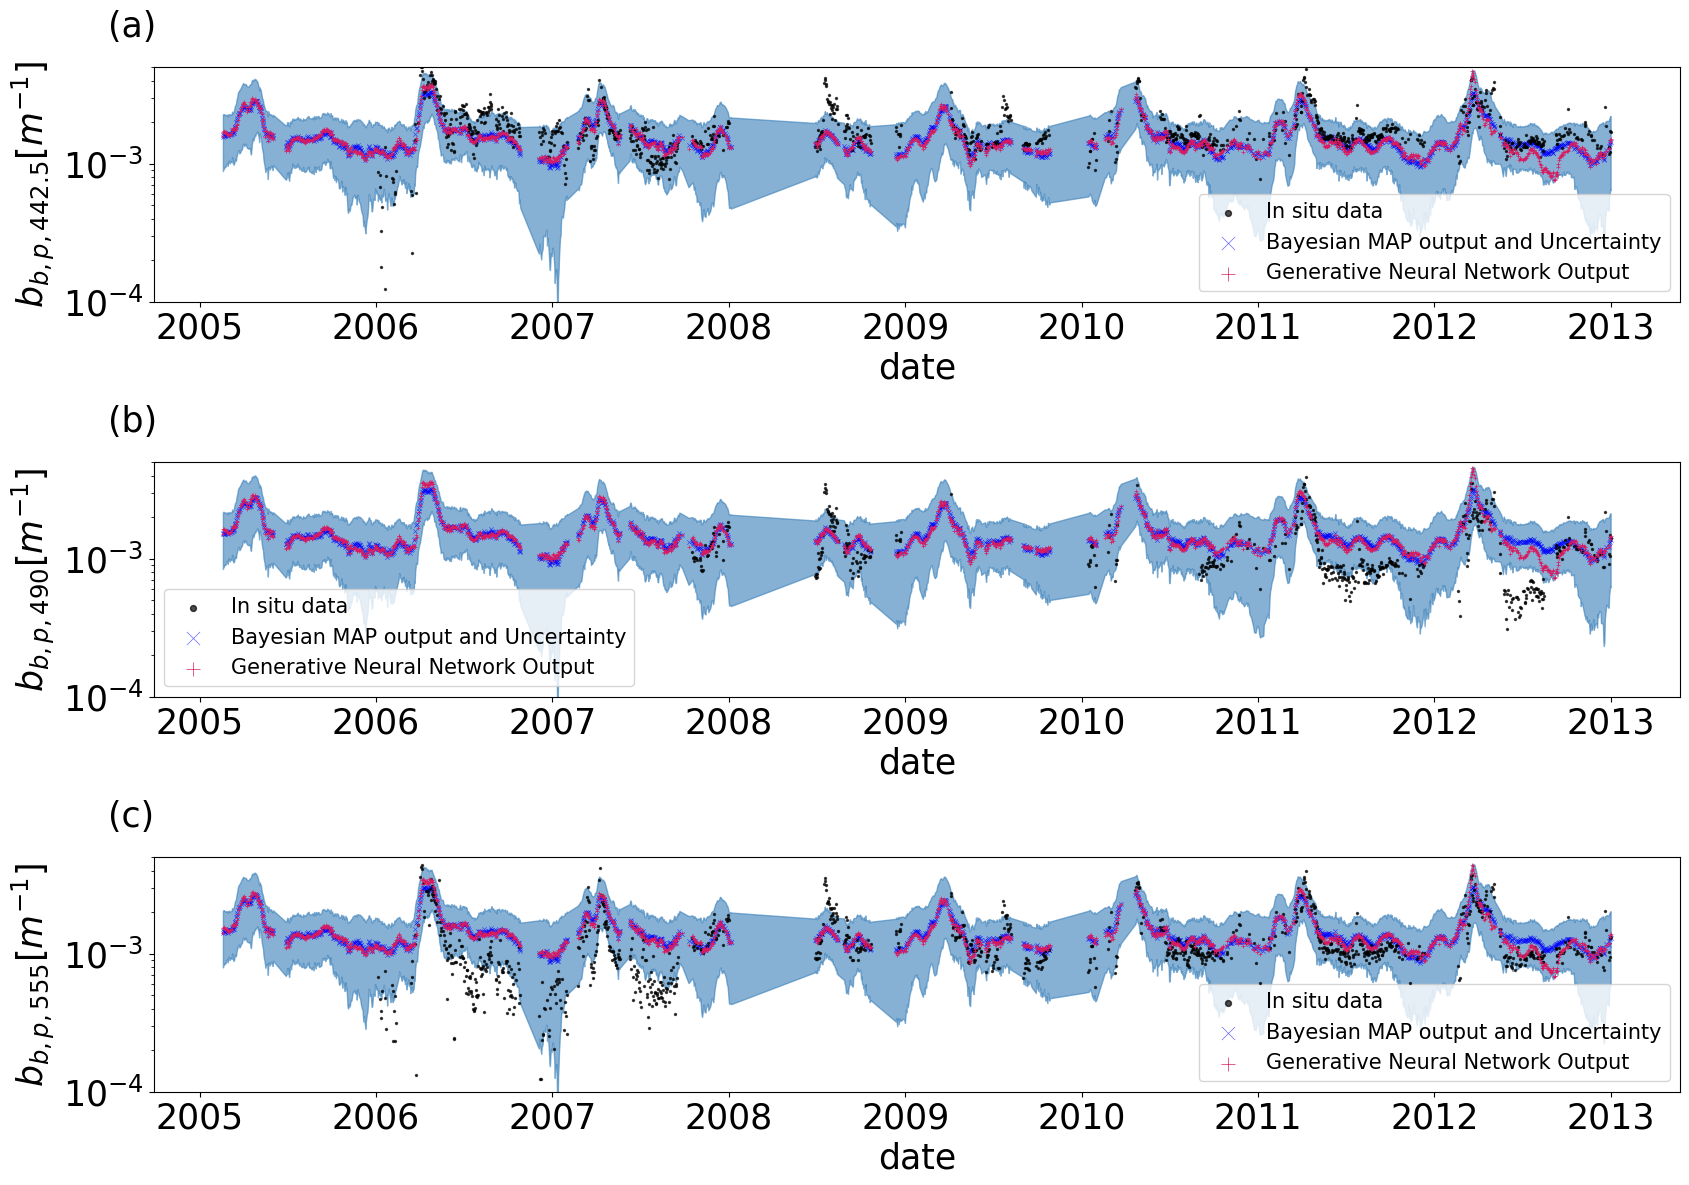

In [9]:
import OGS_one_d_model.PySurfaceData.plot_data_lognormal as plot_l

print(MODEL_HOME)
plot_l.plot_chla(input_data_path = MODEL_HOME + '/results_bayes_lognormal_VAEparam',\
                figname = MODEL_HOME + '/plot_data/chla_lognormal_data_chla_centered.pdf',save=False,date_init = datetime(year=2005,month=1,day=1),\
                statistics=False, num_cols = 1,labels_names=['In situ data','Bayesian MAP output and Uncertainty'],ylim=[],figsize=(17,12),\
          third_data_path = MODEL_HOME + '/VAE_model/results_VAE_VAEparam_chla',log_scale=True)




plot_l.plot_kd(input_data_path = MODEL_HOME + '/results_bayes_lognormal_VAEparam',\
                figname = MODEL_HOME + '/plot_data/kd_lognormal_data_chla_centerd.pdf',save=False,date_init = datetime(year=2005,month=1,day=1),\
                statistics=False, num_cols = 1,labels_names=['In situ data','Bayesian MAP output and Uncertainty'],ylim=[1e-2,0.31],figsize=(17,17),\
        third_data_path = MODEL_HOME + '/VAE_model/results_VAE_VAEparam_chla',log_scale = True)



plot_l.plot_bbp(input_data_path = MODEL_HOME + '/results_bayes_lognormal_VAEparam',\
                figname = MODEL_HOME + '/plot_data/bbp_lognormal_data_chla_centerd.pdf',save=False,date_init = datetime(year=2005,month=1,day=1),\
                statistics=False, num_cols = 1,labels_names=['In situ data','Bayesian MAP output and Uncertainty'],ylim=[],figsize=(17,12),\
         third_data_path = MODEL_HOME + '/VAE_model/results_VAE_VAEparam_chla',log_scale = True)